# Final Maps

For the final, I will be creating a gif of the total parcel value maps, as well as mapping out the recently sold parcels in Chinatown. Both these maps will be utilized to show how policy affects change in Chinatown's spatial landscape. 

In [1]:
# First importing our libraries
import pandas
import geopandas
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import contextily as ctx

### Creating an Array

Once I've imported the libraries, I will create a "columns to keep" dataframe to set up my for loop of importing the data and creating a data array to keep all the different years separate and labelled. 

In [15]:
columns_to_keep = ['TotalValue','geometry','LandValue','YearBuilt']

In [16]:
# Create an array of all years of assessor data using for loop
parcel_dataframes = []

for year in range(2006,2022):
    parcel_data_filepath = "Assessor_Parcels_Data_" + str(year) + "_TRA.geojson"
    parcel_dataframe_raw = geopandas.read_file(parcel_data_filepath)
    parcel_dataframe = parcel_dataframe_raw[columns_to_keep].copy()
    parcel_dataframe['Year'] = year
    parcel_dataframes.append(parcel_dataframe)
    parcel_dataframe['TotalValue'] = parcel_dataframe['TotalValue'].div(1000)

print(parcel_dataframes[0].info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   TotalValue  1095 non-null   float64 
 1   geometry    1095 non-null   geometry
 2   LandValue   1095 non-null   float64 
 3   YearBuilt   1095 non-null   int64   
 4   Year        1095 non-null   int64   
dtypes: float64(2), geometry(1), int64(2)
memory usage: 42.9 KB
None


### Using For Loop to Create Maps

Once the array has been created, I can then use a for loop to print out maps for each labeled dataframe. For the maps, I made sure that the legend was off to the side and that the fontsize was adjusted to not take up too much room.

Additionally, for the purposes of making a gif, I added one line of code at the bottom of the cell to save each map to my jupyternotebook folder as it was created, which would then be used as the images looped in my gif.

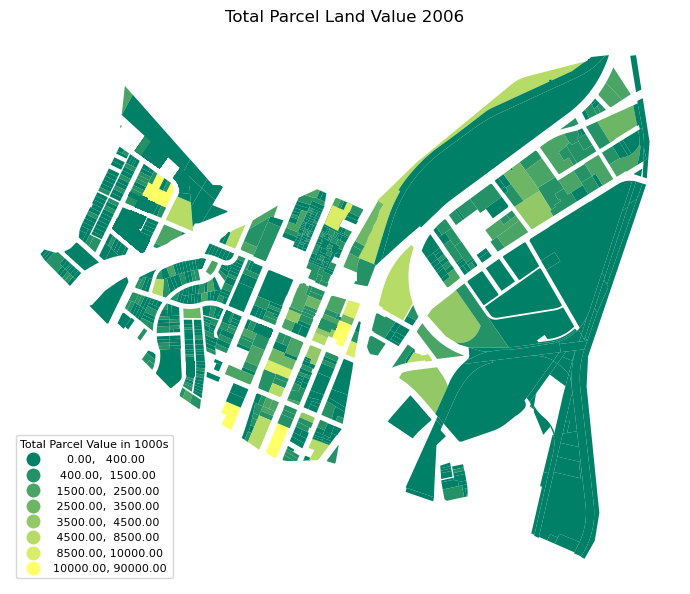

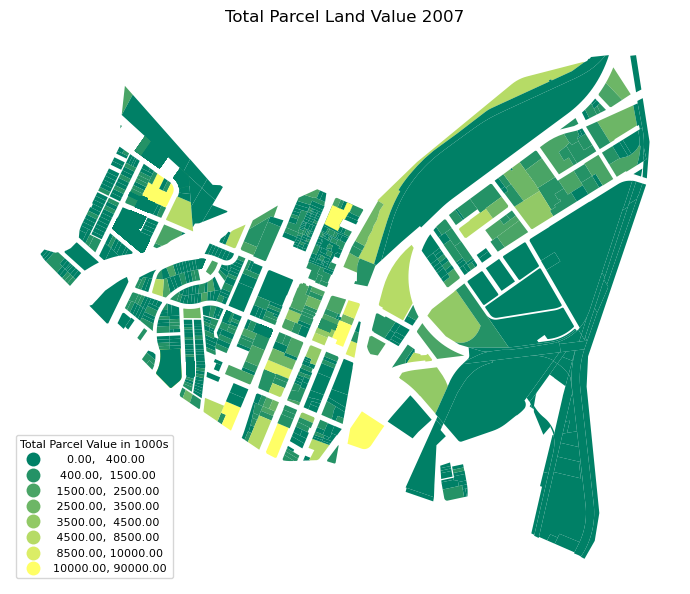

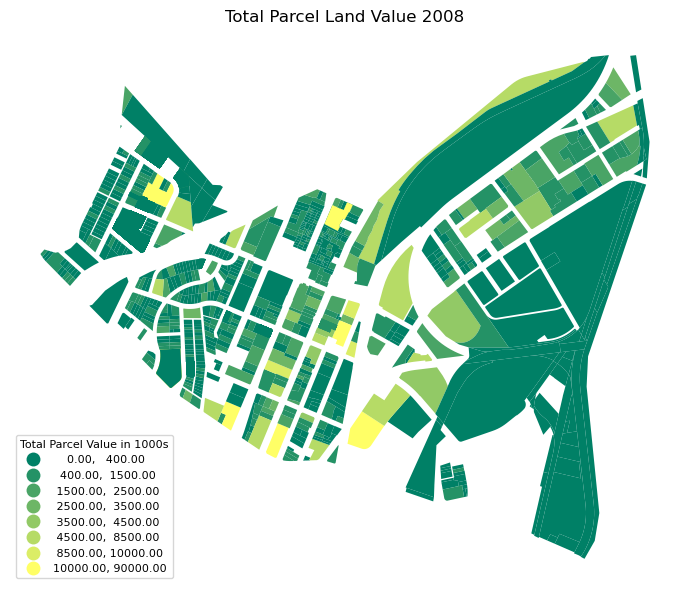

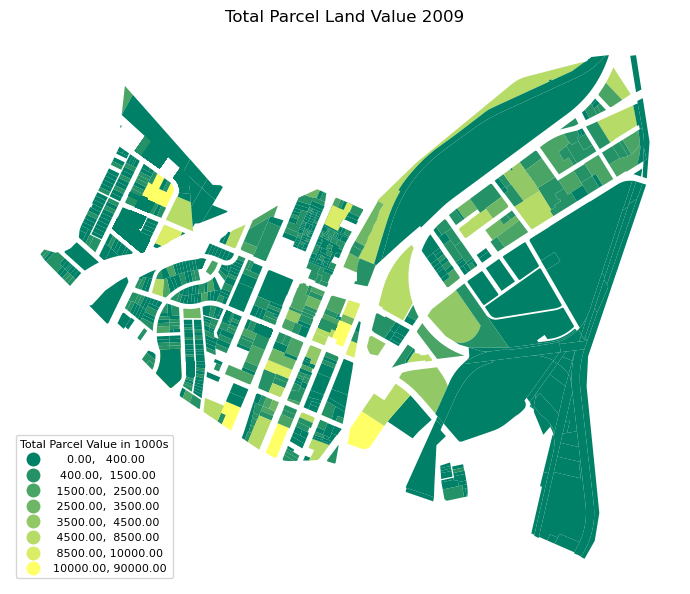

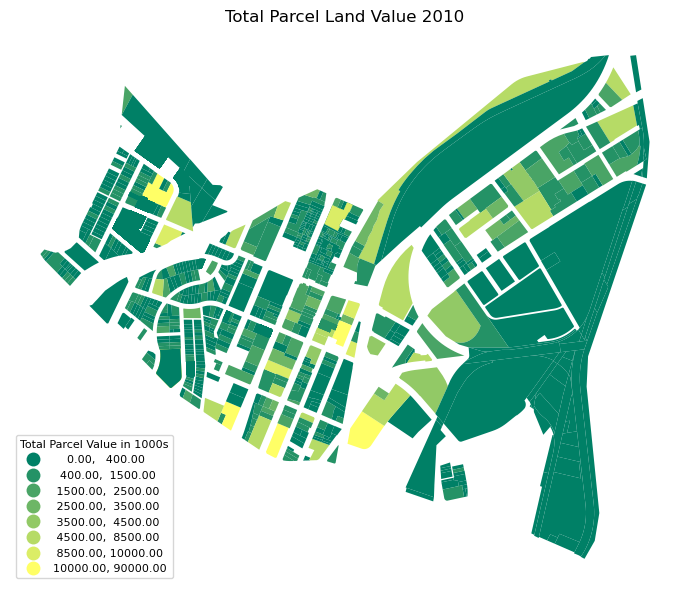

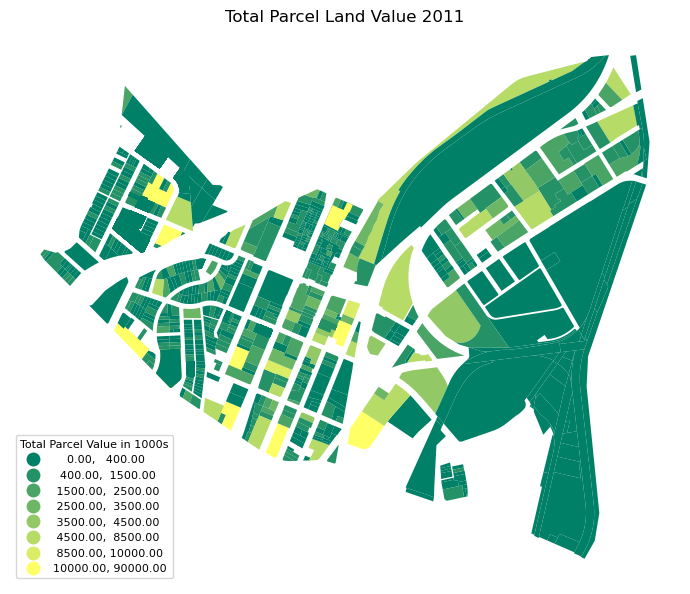

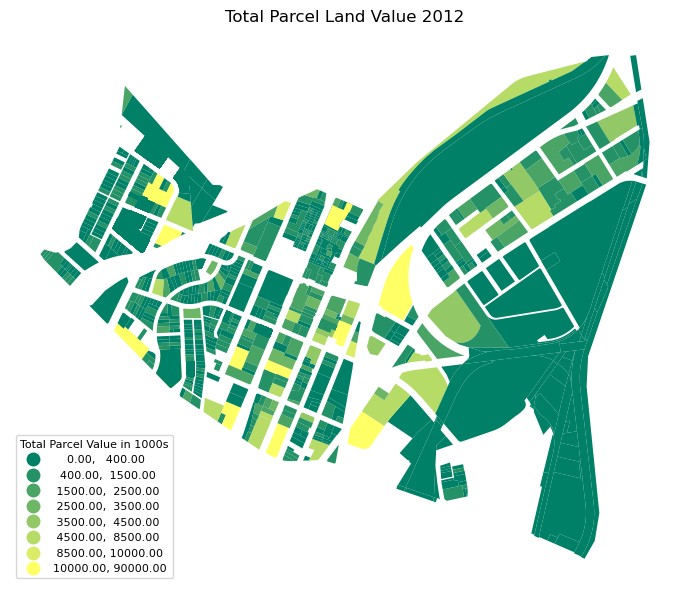

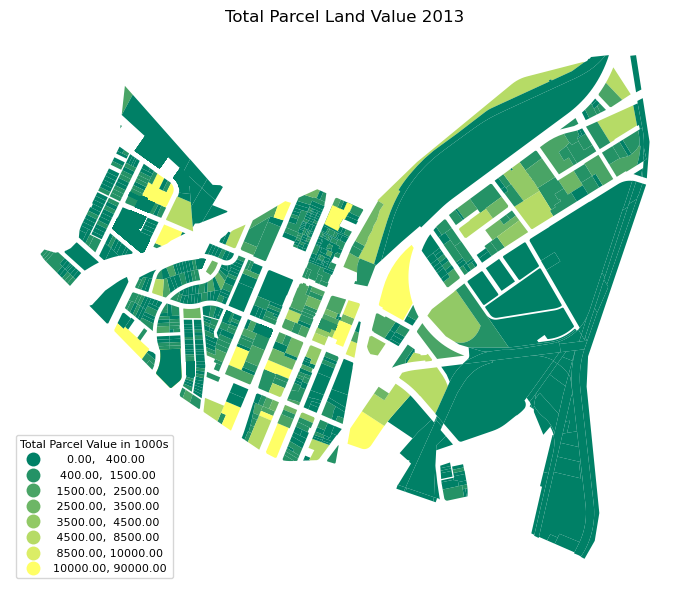

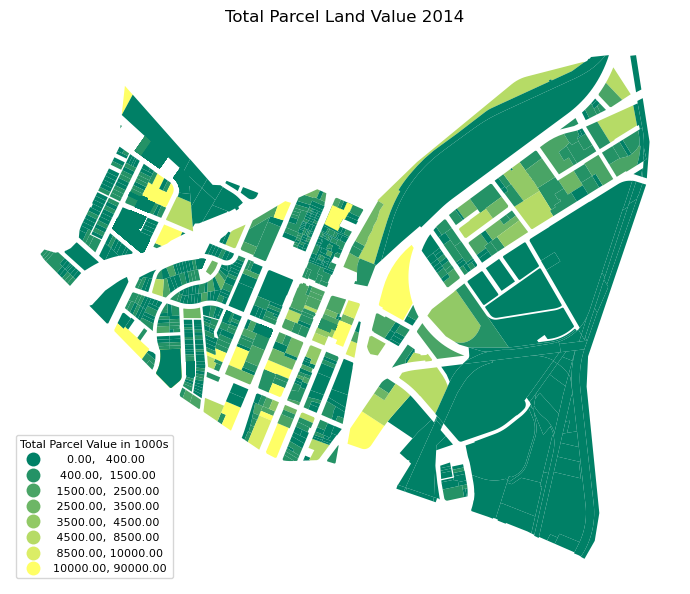

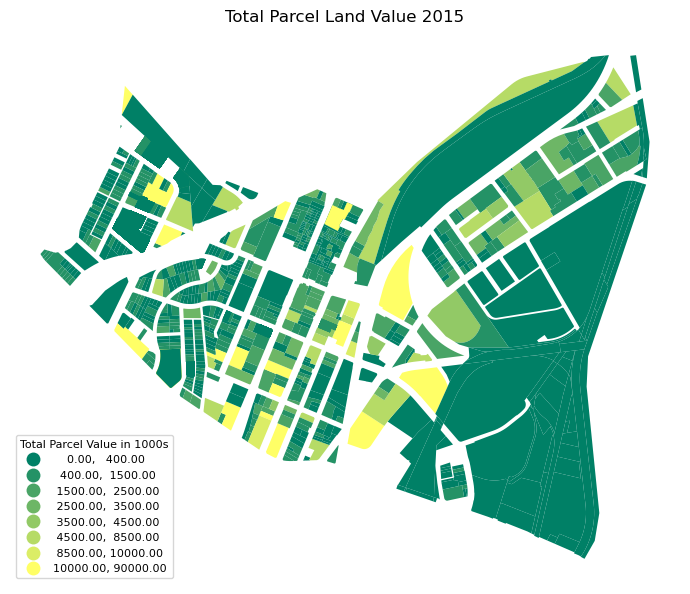

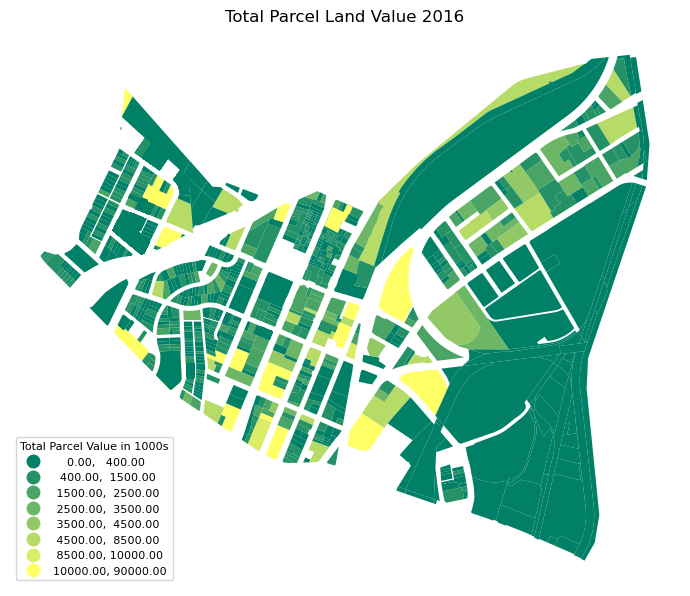

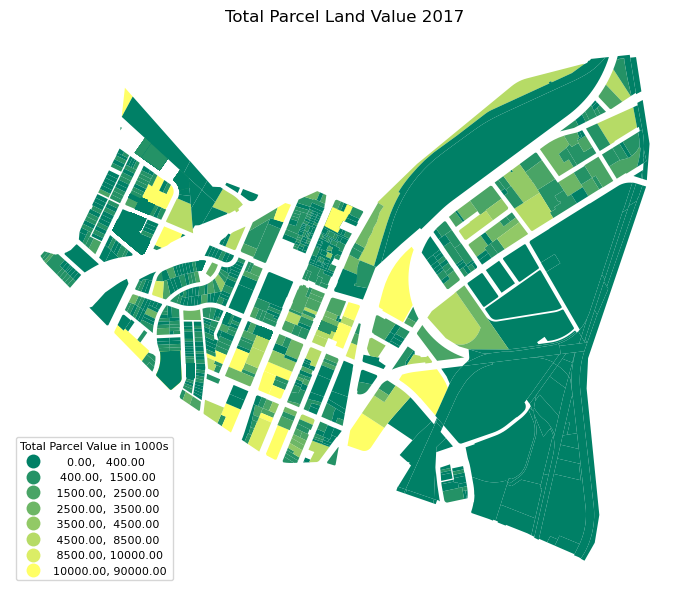

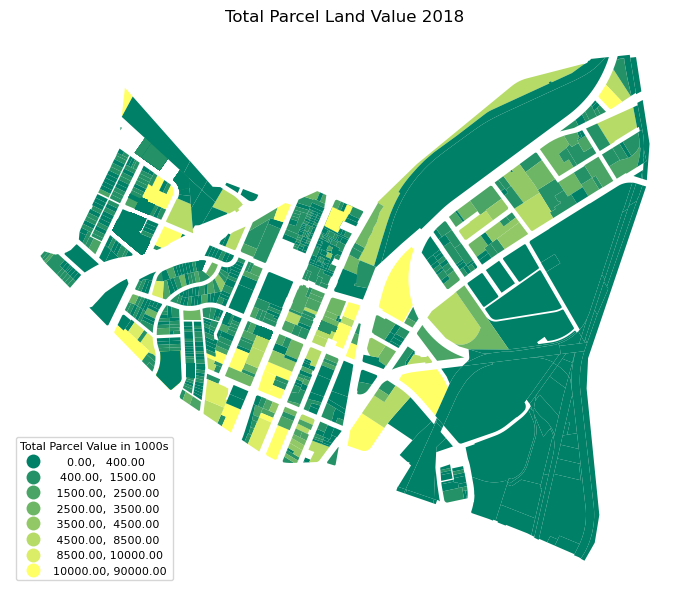

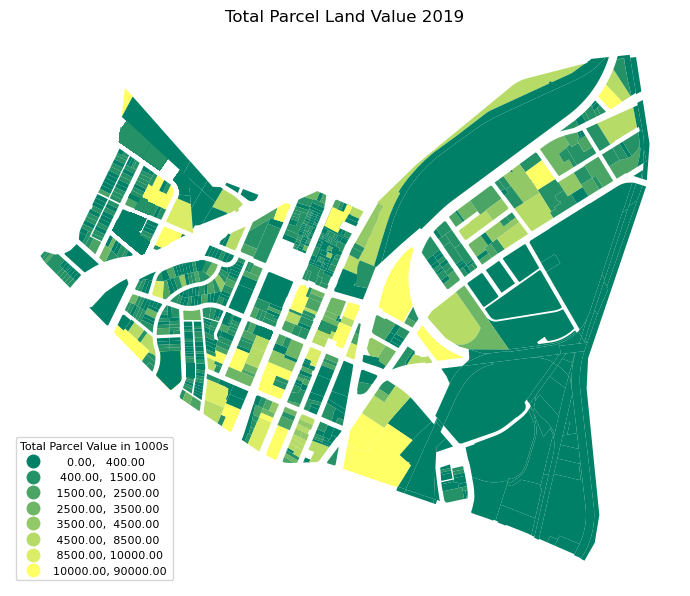

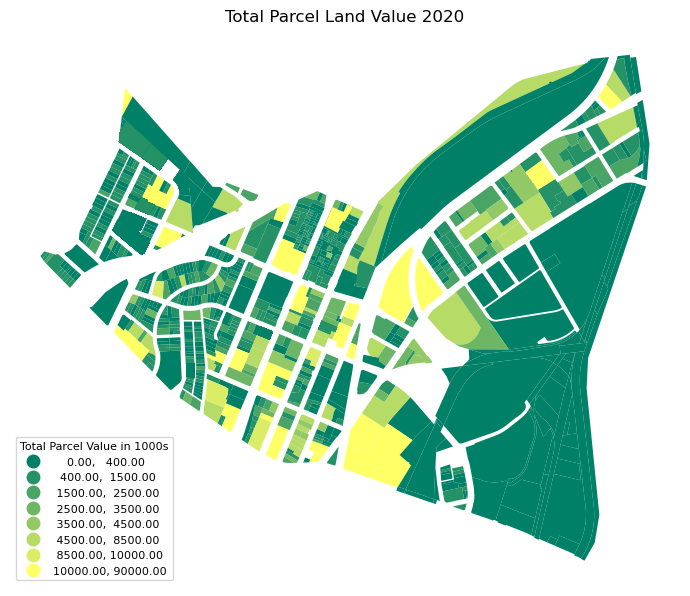

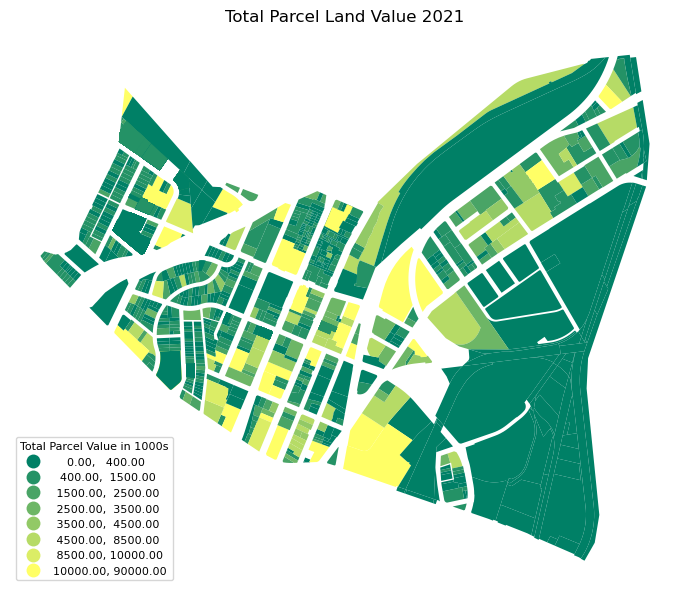

In [39]:
# Now create for loop to print out all maps for Total Value

for parcel_dataframe in parcel_dataframes:
    fig, ax = plt.subplots(figsize=(7,7))
    parcel_dataframe.plot(ax=ax,
                          column='TotalValue', cmap='summer',
                          legend=True,
                       scheme='userdefined',
                      legend_kwds={'title': "Total Parcel Value in 1000s", 'prop': {'size': 8}, 'title_fontsize': 8, 'loc': 'lower left'},
                  classification_kwds=dict(bins=[400,1500,2500,3500,4500,8500,10000,90000]))
    ax.set_title('Total Parcel Land Value ' +str(parcel_dataframe['Year'][0] ))
    ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('totalparcelvalue' + str(parcel_dataframe['Year'][1]) + '.jpg', dpi=199)
   # Uncomment the code line above to save each map produced to Jupyter notebook folder 

### Creating A Gif

I found a gif-creating library and imported here to loop the years of parcel value maps into a gif that visualizes the heightening value of parcels in Chinatown over time. 

In [40]:
import imageio.v2 as imageio

unitmapsR = ['totalparcelvalue2006.jpg', 'totalparcelvalue2010.jpg', 'totalparcelvalue2014.jpg', 'totalparcelvalue2018.jpg', 'totalparcelvalue2021.jpg']

images = []
for unitmap in unitmapsR:
        images.append(imageio.imread(unitmap))
imageio.mimsave('Totalparcelvalue.gif',images,duration=1.0)

# Uncomment the code lines above to create a gif with map images saved to jupyter notebook

## Mapping Recently Sold Parcels

Now I'll take a look at the recently sold parcel data and separate by use type. The data is from ArcGIS, so Yoh wrote us a function that allows us to import data from ArcGIS server, as well as bypassing the 1000 record limit imposed by ArcGIS Server so we can download the entire dataset.

In [19]:
import numpy as np
import pandas as pd
import geopandas as gpd
import urllib.parse
import requests
import matplotlib.pyplot as plt
import contextily as ctx

def query_arcgis_feature_server(url_feature_server=''):
    '''
    This function downloads all of the features available on a given ArcGIS 
    feature server. The function is written to bypass the limitations imposed
    by the online service, such as only returning up to 1,000 or 2,000 featues
    at a time.

    Parameters
    ----------
    url_feature_server : string
        Sting containing the URL of the service API you want to query. It should 
        end in a forward slash and look something like this:
        'https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Counties/FeatureServer/0/'

    Returns
    -------
    geodata_final : gpd.GeoDataFrame
        This is a GeoDataFrame that contains all of the features from the 
        Feature Server. After calling this function, the `geodata_final` object 
        can be used to store the data on disk in several different formats 
        including, but not limited to, Shapefile (.shp), GeoJSON (.geojson), 
        GeoPackage (.gpkg), or PostGIS.
        See https://geopandas.org/en/stable/docs/user_guide/io.html#writing-spatial-data
        for more details.

    '''
    if url_feature_server == '':
        geodata_final = gpd.GeoDataFrame()
        return geodata_final

    # Fixing last character in case the URL provided didn't end in a 
    # forward slash
    if url_feature_server[-1] != '/':
        url_feature_server = url_feature_server + '/'
    
    # Getting the layer definitions. This contains important info such as the 
    # name of the column used as feature_ids/object_ids, among other things.
    layer_def = requests.get(url_feature_server + '?f=pjson').json()
    
    # The `objectIdField` is the column name used for the 
    # feature_ids/object_ids
    # fid_colname = layer_def['objectIdField']
    fid_colname = 'OBJECTID'

    
    # The `maxRecordCount` tells us the maximum number of records this REST 
    # API service can return at once. The code below is written such that we 
    # perform multiple calls to the API, each one being short enough never to 
    # go beyond this limit.
    record_count_max = layer_def['maxRecordCount']
    
    # Part of the URL that specifically requests only the object IDs
    url_query_get_ids = (f'query?f=geojson&returnIdsOnly=true'
                         f'&where={fid_colname}+is+not+null')
    
    url_comb = url_feature_server + url_query_get_ids
    
    # Getting all the object IDs
    service_request = requests.get(url_comb)
    # print(service_request.json())
    all_objectids = np.sort(service_request.json()['objectIds'])
    
    # This variable will store all the parts of the multiple queries. These 
    # parts will, at the end, be concatenated into one large GeoDataFrame.
    geodata_parts = []
    
    # This part of the query is fixed and never actually changes
    url_query_fixed = ('query?f=geojson&outFields=*&where=')
    
    # Identifying the largest query size allowed per request. This will dictate 
    # how many queries will need to be made. We start the search at
    # the max record count, but that generates errors sometimes - the query 
    # might time out because it's too big. If the test query times out, we try 
    # shrink the query size until the test query goes through without 
    # generating a time-out error.
    block_size = min(record_count_max, len(all_objectids))
    worked = False
    while not worked:
        # Moving the "cursors" to their appropriate locations
        id_start = all_objectids[0]
        id_end = all_objectids[block_size-1]

        readable_query_string = (f'{fid_colname}>={id_start} '
                                 f'and {fid_colname}<={id_end}')
        
        url_query_variable =  urllib.parse.quote(readable_query_string)
    
        url_comb = url_feature_server + url_query_fixed + url_query_variable
        
        url_get = requests.get(url_comb)
        
        if 'error' in url_get.json():
            block_size = int(block_size/2)+1
        else:
            geodata_part = gpd.read_file(url_get.text)
            
            geodata_parts.append(geodata_part.copy())
            worked = True
    
    # Performing the actual query to the API multiple times. This skips the 
    # first few rows/features in the data because those rows were already 
    # captured in the query performed in the code chunk above.
    for i in range(block_size, len(all_objectids), block_size):
        # Moving the "cursors" to their appropriate locations and finding the 
        # limits of each block
        sub_list = all_objectids[i:i + block_size]
        id_start = sub_list[0]
        id_end = sub_list[-1]

        readable_query_string = (f'{fid_colname}>={id_start} '
                                 f'and {fid_colname}<={id_end}')
        
        # Encoding from readable text to URL
        url_query_variable =  urllib.parse.quote(readable_query_string)
    
        # Constructing the full request URL
        url_comb = url_feature_server + url_query_fixed + url_query_variable
        
        # Actually performing the query and storing its results in a 
        # GeoDataFrame
        geodata_part =  (gpd.read_file(url_comb, 
                                       driver='GeoJSON'))
        
        # Appending the result to `geodata_parts`
        if geodata_part.shape[0] > 0:
            geodata_parts.append(geodata_part)

    # Concatenating all of the query parts into one large GeoDataFrame
    geodata_final = (pd.concat(geodata_parts, 
                               ignore_index=True)
                     .sort_values(by=fid_colname)
                     .reset_index(drop=True))
    
    # Checking if any object ID is missing
    ids_queried = set(geodata_final[fid_colname])
    for i,this_id in enumerate(all_objectids):
        if this_id not in ids_queried:
            print('WARNING! The following ObjectID is missing from the final '
                  f'GeoDataFrame: ObjectID={this_id}')
            pass
    
    # Checking if any object ID is included twice
    geodata_temp = geodata_final[[fid_colname]].copy()
    geodata_temp['temp'] = 1
    geodata_temp = (geodata_temp
                    .groupby(fid_colname)
                    .agg({'temp':'sum'})
                    .reset_index())
    geodata_temp = geodata_temp.loc[geodata_temp['temp']>1].copy()
    for i,this_id in enumerate(geodata_temp[fid_colname].values):
        n_times = geodata_temp['temp'].values[i]
        print('WARNING! The following ObjectID is included multiple times in'
              f'the final GeoDataFrame: ObjectID={this_id}\tOccurrences={n_times}')
    
    return geodata_final

In [20]:
# define your arc server url endpoint
url='https://egispais.gis.lacounty.gov/pais/rest/services/PAIS/pais_sales_parcels/MapServer/0/'

In [21]:
# make the function call and put results in a variable 'parcel'
parcel = query_arcgis_feature_server(url)

### Merging the Data

Next I'm going to spatial join the ArcGIS data to Parcel Geographic boundaries, but first I have to rename the column title in the ArcGIS data from AIN to APN, so I can merge on that attribute. AIN and APN are interchangeable, APNs are most commonly referred to as Assessor Parcel Numbers, but may also be known as Assessor's Identification Numbers (AINs). 

I'll import parcel geographic boundaries downloaded from LA County GIS Hub, clipped to Chinatown boundary. Then I'll merge the ArcGIS df and the parcel df

In [22]:
chinatown_parcels = gpd.read_file('LA_County_Parcels_Feature_Clip.zip')

In order to prevent duplicate columns in the merge, I will first create a df with the difference of the columns between my two dataframes. Thenm I will merge selecting only the non-duplicate columns.

In [23]:
columns_to_use = chinatown_parcels.columns.difference(parcel.columns).union(['AIN'])
columns_to_use

Index(['AIN', 'APN', 'AgencyClas', 'AgencyName', 'AgencyType', 'Assr_Index',
       'Assr_Map', 'Bathrooms1', 'Bathrooms2', 'Bathrooms3', 'Bathrooms4',
       'Bathrooms5', 'Bedrooms1', 'Bedrooms2', 'Bedrooms3', 'Bedrooms4',
       'Bedrooms5', 'CENTER_LAT', 'CENTER_LON', 'CENTER_X', 'CENTER_Y',
       'DesignTy_1', 'DesignTy_2', 'DesignTy_3', 'DesignTy_4', 'DesignType',
       'Effectiv_1', 'Effectiv_2', 'Effectiv_3', 'Effectiv_4', 'EffectiveY',
       'LAT_LON', 'LegalDes_1', 'LegalDes_2', 'LegalDes_3', 'LegalDes_4',
       'LegalDes_5', 'LegalDescL', 'LegalDescr', 'OBJECTID_1', 'ParcelCrea',
       'ParcelType', 'QualityC_1', 'QualityC_2', 'QualityC_3', 'QualityC_4',
       'QualityCla', 'Roll_Fix_1', 'Roll_Fixtu', 'Roll_HomeO', 'Roll_ImpBa',
       'Roll_ImpVa', 'Roll_LandB', 'Roll_LandV', 'Roll_Per_1', 'Roll_PersP',
       'Roll_RealE', 'Roll_Year', 'SQFTmain1', 'SQFTmain2', 'SQFTmain3',
       'SQFTmain4', 'SQFTmain5', 'Shape_Area', 'Shape_Leng', 'SitusAddre',
       'SitusCity',

In [24]:
recently_sold_df = parcel.merge(chinatown_parcels[columns_to_use], on='AIN')

I'll trim the columns in the merged Recently Sold df to just the data I'm interested in

In [25]:
desired_columns = ['AIN','SitusFullA','LAT_LON','YearBuilt1','USETYPE','geometry']
recently_sold_df_clipped = recently_sold_df[desired_columns].copy()
recently_sold_df_clipped.sample(5)

AIN                                     SitusFullA  \
56  5406024048   957 N FIGUEROA TER #303 LOS ANGELES CA 90012   
4   5407017028  630 N GRAND AVE UNIT 103 LOS ANGELES CA 90012   
41  5406024040   957 N FIGUEROA TER #101 LOS ANGELES CA 90012   
14  5414005048         969 CHUNG KING RD LOS ANGELES CA 90012   
30  5406022071       1007 FIGUEROA TER C LOS ANGELES CA 90012   

                   LAT_LON YearBuilt1 USETYPE  \
56  34.067968, -118.243649       2020     CND   
4   34.061431, -118.243022       1982     CND   
41  34.067968, -118.243649       2020     CND   
14  34.066497, -118.238305       1950     C/I   
30  34.068824, -118.244928       2002     CND   

                                             geometry  
56  POLYGON ((-118.24345 34.06809, -118.24345 34.0...  
4   POLYGON ((-118.24287 34.06158, -118.24288 34.0...  
41  POLYGON ((-118.24345 34.06809, -118.24345 34.0...  
14  POLYGON ((-118.23837 34.06657, -118.23838 34.0...  
30  POLYGON ((-118.24462 34.06897, -118.24473 34.0...

Looking at the Usetype column, I'm going to replace the entries so that instead of the code, we'll see the actual label associated with it. For example, instead of SFR, the listing will state "Single Family Residence." This will make the legend easier to read when we create a map from this data.

In [26]:
recently_sold_df_clipped['USETYPE'] = recently_sold_df_clipped['USETYPE'].replace(['C/I', 'CND', 'OTH', 'R-I', 'SFR', 'VAC'], ['Commercial / Industrial', 'Condominium', 'Other', 'Multiple Family Residence', 'Single Family Residence', 'Vacant Land'])


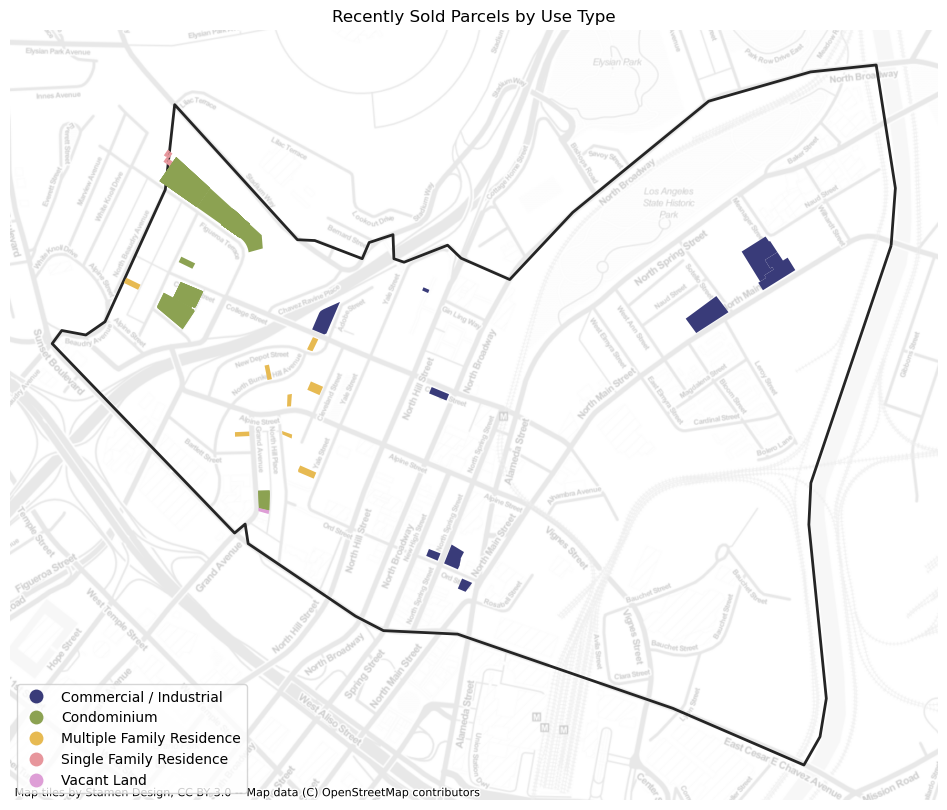

In [27]:
fig, ax = plt.subplots(figsize=(12,10))
# Plot Chinatown neighborhood boundaries
chinatown_neighborhood = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?where=name%20%3D%20'CHINATOWN'&outFields=*&outSR=4326&f=geojson")
chinatown_neighborhood.plot(ax=ax,facecolor='none',edgecolor='#252525',linewidth=2)
ax.axis('off')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite,crs=4326,alpha=0.2)
# Plot existing market-rate developments
recently_sold_df_clipped.plot(ax=ax,
                              column = 'USETYPE',
                              cmap='tab20b',
                              legend=True,
         legend_kwds={'loc':'lower left'})
#Add title
ax.set_title('Recently Sold Parcels by Use Type')

fig.savefig('recentlysoldparcels.pdf')

## Takeaways

Lookinng at both groupings of maps, we see that over the years policy incentives for developers and real estate forces have inflated the price of land and developments in Chinatown. Chinatown's proximity to downtown, which has gone through major revitilization in the past 20 years - both from pressure within city hall and private commercial actors - has now made it's previously disinvested neighborhoods ripe for redevelopment, because of their previously low land cost and older buildings label the area as "underutilized" in the eyes of private market-rate developers. The implementation of economic and housing revitilization measures from the 2013 CASP plan and the 2016 TOC started and strengthened this trend, with LA's 2022 Housing Element promising more developer activity in the area, as large parts of Chinatown are schedule to be rezoned/redeveloped to account for the city's high RHNA housing allocation. 